In [1]:
#import things
# import Libraries
# Built-in Python libraries
import os # functions for interacting w operating system

# 3rd-party libraries
import numpy as np # module for low-level scientific computing
import pymc3 as pm
import theano.tensor as tt
import pickle
import pylab as plt
import numpy as np
from scipy import stats
import pandas as pd


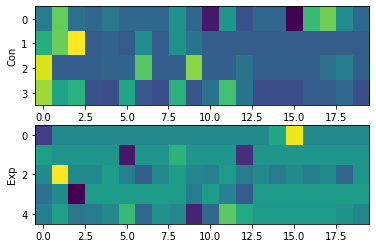

In [33]:
#Get name of directory where the data files and pickle file sits, and change to that directory for processing
dir_name = '/media/fastdata/brad_changepoint'
os.chdir(dir_name)

con_name = 'con_zscoreddiff_rearingduration.csv'
con_df = pd.read_csv(con_name,header=None)
con_data_mat = con_df.to_numpy()

exp_name = 'exp_zscoreddiff_rearingduration.csv'
exp_df = pd.read_csv(exp_name,header=None)
exp_data_mat = exp_df.to_numpy()

znormdiff_matrix = exp_data_mat

n_count_data = con_data_mat.shape[-1]
fig,ax = plt.subplots(2,1)
ax[0].imshow(con_data_mat,aspect='auto')
ax[0].set_ylabel('Con');
ax[1].imshow(exp_data_mat,aspect='auto')
ax[1].set_ylabel('Exp');

## Test Data

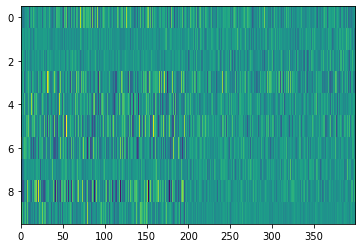

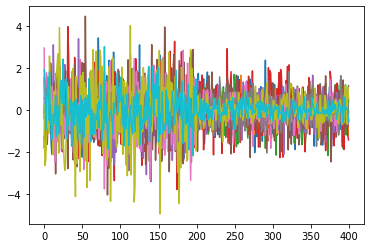

In [90]:
length = 200
row_count = 10
mu1 = np.random.random((1,row_count))*0
mu2 = np.random.random((1,row_count))*0
sigma1 = np.random.random((1,row_count))*3
sigma2 = np.random.random((1,row_count))
cov1 = np.eye(row_count)*sigma1
cov2 = np.eye(row_count)*sigma2

test_data = np.concatenate(
    (stats.multivariate_normal.rvs(mu1.flatten(),cov1,length),
     stats.multivariate_normal.rvs(mu2.flatten(),cov2,length))).T
plt.imshow(test_data,aspect='auto');
plt.figure()
plt.plot(test_data.T);

In [91]:
def model_generator(array):

    with pm.Model() as model:

        # Define shared "Data" holder to fit same model to different datasets 
        data = pm.Data("data", array)

        rows, timebins = np.array(model["data"].get_value()).shape
        idx = np.arange(timebins)

        # Defining variables with priors
        alpha = np.array(model["data"].get_value()).mean()  # Recall count_data is the
                                       # variable that holds our txt counts
        mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1, shape = rows)
        mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1, shape = rows)
        sigma = pm.HalfCauchy('sig', 1, shape = rows)

        # Uniform prior
        tau_latent = pm.Uniform('tau_latent', 0, 1)

        tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
        # Using sigmoid rather than switch is supposed to be better
        # for sampler
        weight = tt.nnet.sigmoid(2 * (idx - tau))[np.newaxis,:]
        mu_ = (1 - weight) * mu_1[:,np.newaxis] + weight * mu_2[:,np.newaxis]
        sigma_ = np.ones((1,timebins))*sigma.flatten()[:,np.newaxis]

        observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=data)
        
    return model

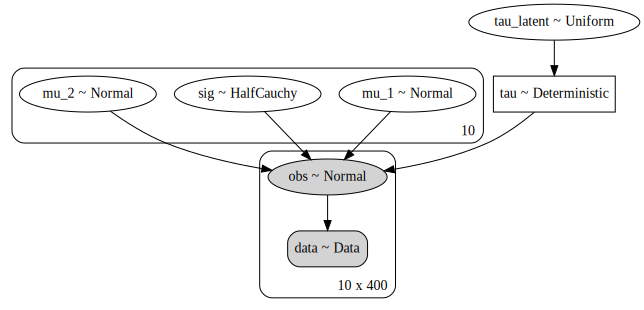

In [92]:
model = model_generator(test_data)
pm.model_to_graphviz(model)

In [93]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [01:36<00:00, 41.38draws/s] 
The acceptance probability does not match the target. It is 0.9621536905819188, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9672597599195891, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


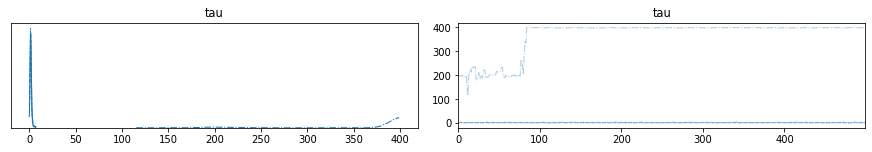

In [94]:
pm.traceplot(trace, varnames = ['tau']);

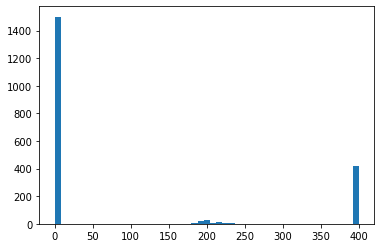

In [95]:
plt.hist(trace['tau'],bins = np.linspace(0,2*length));

In [96]:
ppc = pm.sample_posterior_predictive(trace, samples=100, model=model)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 103.33it/s]


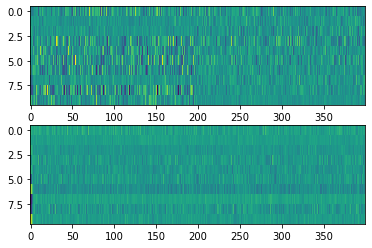

In [97]:
fig,ax = plt.subplots(2,1)
ax[0].imshow(test_data,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')

## Actual Data

In [80]:
model = model_generator(con_data_mat)
with model:
    con_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2319.11draws/s]


In [81]:
model = model_generator(exp_data_mat)
with model:
    exp_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1873.81draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


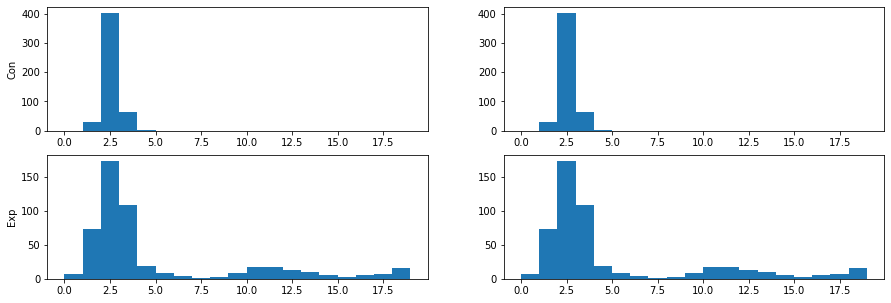

In [82]:
con_tau_array = np.array([this_trace["tau"] for this_trace in con_trace])
exp_tau_array = np.array([this_trace["tau"] for this_trace in exp_trace])

fig, ax = plt.subplots(2,2, figsize = (15,5))
ax[0,0].hist(con_tau_array.T, np.arange(20), stacked = 'true');
ax[0,1].hist(con_tau_array.flatten(), np.arange(20), stacked = 'true');
ax[1,0].hist(exp_tau_array.T, np.arange(20), stacked = 'true');
ax[1,1].hist(exp_tau_array.flatten(), np.arange(20), stacked = 'true');

ax[0,0].set_ylabel('Con');
ax[1,0].set_ylabel('Exp');

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:10<00:00, 92.68it/s]


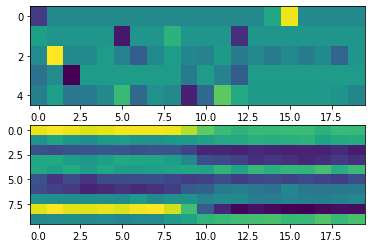

In [83]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
fig,ax=plt.subplots(2,1)
ax[0].imshow(znormdiff_matrix,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')

# Temporal Shuffled comparison

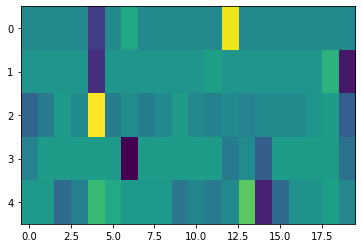

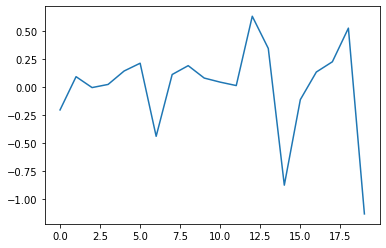

In [34]:
#Temporal shuffle
znormdiff_shuffle = np.array([np.random.permutation(x) for x in exp_data_mat]) 
zdiff_shuffle_mean = np.nanmean(znormdiff_shuffle,axis=0)

#count_data
count_data_shuffle = np.sum(znormdiff_shuffle,axis=0)
count_data_shuffle = zdiff_shuffle_mean
n_count_data = len(count_data_shuffle)

plt.imshow(znormdiff_shuffle,aspect='auto')
plt.figure()
plt.plot(count_data_shuffle)

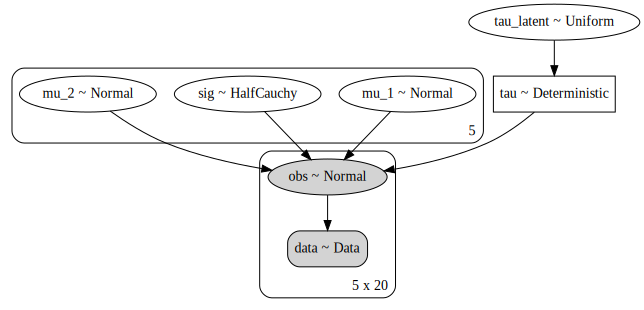

In [72]:
model = model_generator(znormdiff_matrix)

pm.model_to_graphviz(model)

In [36]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2326.29draws/s]


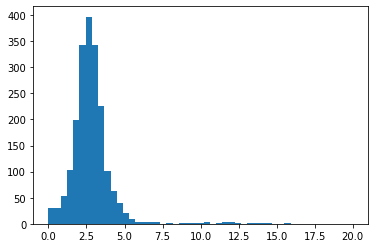

In [37]:
plt.hist(trace['tau'],bins = np.linspace(0,znormdiff_shuffle.shape[-1]));

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:09<00:00, 106.10it/s]


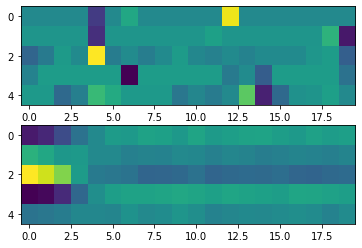

In [38]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
fig,ax=plt.subplots(2,1)
ax[0].imshow(znormdiff_shuffle,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')

# Random shuffle comparison

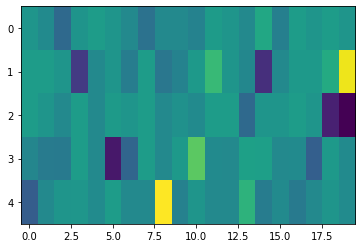

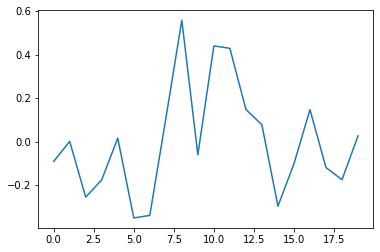

In [39]:
#Temporal shuffle
mat_shape = znormdiff_matrix.shape
znormdiff_shuffle =  np.reshape(np.random.permutation(znormdiff_matrix.flatten()), mat_shape)
zdiff_shuffle_mean = np.nanmean(znormdiff_shuffle,axis=0)

#count_data
count_data_shuffle = np.sum(znormdiff_shuffle,axis=0)
count_data_shuffle = zdiff_shuffle_mean
n_count_data = len(count_data_shuffle)

plt.imshow(znormdiff_shuffle,aspect='auto')
plt.figure()
plt.plot(count_data_shuffle)

In [40]:
with model:
    pm.set_data({"data": znormdiff_shuffle})
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2075.22draws/s]


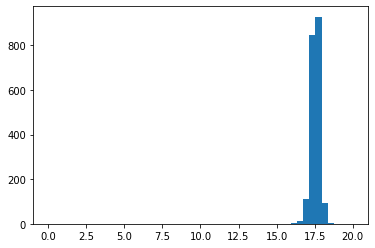

In [41]:
plt.hist(trace['tau'],bins = np.linspace(0,znormdiff_shuffle.shape[-1]));

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:09<00:00, 105.90it/s]


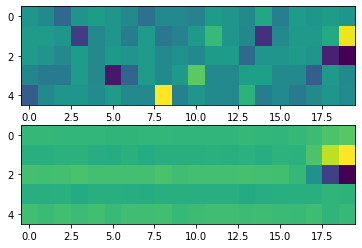

In [42]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
fig,ax=plt.subplots(2,1)
ax[0].imshow(znormdiff_shuffle,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')

## True random test

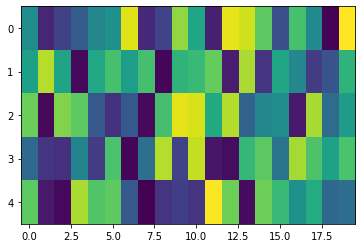

In [43]:
znormdiff_shuffle = np.random.random((5,len(idx)))
plt.imshow(znormdiff_shuffle,aspect='auto')

In [44]:
with model:
    pm.set_data({"data": znormdiff_shuffle})
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 769.86draws/s] 
The acceptance probability does not match the target. It is 0.7079337067609601, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6076930799145044, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


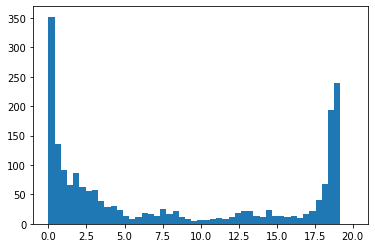

In [45]:
plt.hist(trace['tau'],bins = np.linspace(0,znormdiff_shuffle.shape[-1]));

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:09<00:00, 106.88it/s]


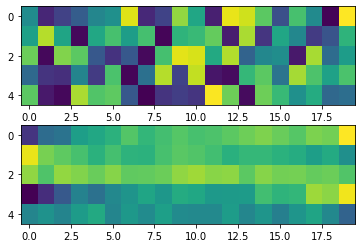

In [46]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
fig,ax=plt.subplots(2,1)
ax[0].imshow(znormdiff_shuffle,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')